<a href="https://colab.research.google.com/github/mishra28soumya/TensorFlow-for-Deep-Learning/blob/master/3_Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying Images of Clothing
build and train a neural network to classify images of clothing, like sneakers and shirts.

# Install and import dependencies
We'll need TensorFlow Datasets, an API that simplifies downloading and accessing datasets, and provides several sample datasets to work with.

In [1]:
!pip install -U tensorflow_datasets

Requirement already up-to-date: tensorflow_datasets in /usr/local/lib/python3.6/dist-packages (2.0.0)


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [3]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf 

TensorFlow 2.x selected.


In [0]:
#Import tensorflow datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

In [0]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Import the Fashion MNIST dataset
This dataset contains 70000 grayscale images in 10 categories.

In [6]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.0.incompleteYRF6I9/fashion_mnist-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.0.incompleteYRF6I9/fashion_mnist-test.tfrecord
Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.0. Subsequent calls will reuse this data.


The images are 28  ×  28 arrays, with pixel values in the range [0, 255]. The labels are an array of integers, in the range [0, 9]. These correspond to the class of clothing the image represents:

Label	Class

0	T-shirt/top

1	Trouser

2	Pullover

3	Dress

4	Coat

5	Sandal

6	Shirt

7	Sneaker

8	Bag

9	Ankle boot


Each image is mapped to a single label. Since the class names are not included with the dataset, store them here to use later when plotting the images:


In [0]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

# Explore the data

In [8]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples ",num_train_examples)
print("Number of testing examples ",num_test_examples)

Number of training examples  60000
Number of testing examples  10000


# Proprocess the data
The value of each pixel in the image data is an integer in the range [0,255]. For the model to work properly, these values need to be normalized to the range [0,1]. So here we create a normalization function, and then apply it to each image in the test and train datasets.

In [0]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# The map function applies the normalize function to each element in the train and test datasets
train_dataset = train_dataset.map(normalize)
train_dataset = test_dataset.map(normalize)

#The first time you use the datase, the images will be loaded from disk
# Caching will keep them in memory, making training faster
train_dataset = train_dataset.cache()
test_dataset = test_dataset.cache()


#Explore the processed data

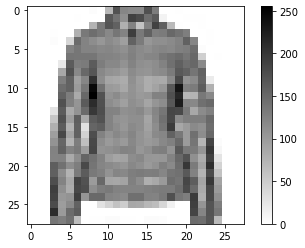

In [10]:
# Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))

# Plot the image - voila a piece of fashion clothing
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

Display the first 25 images from the training set and display the class name below each image. Verify that the data is in the correct format and we're ready to build and train the network.



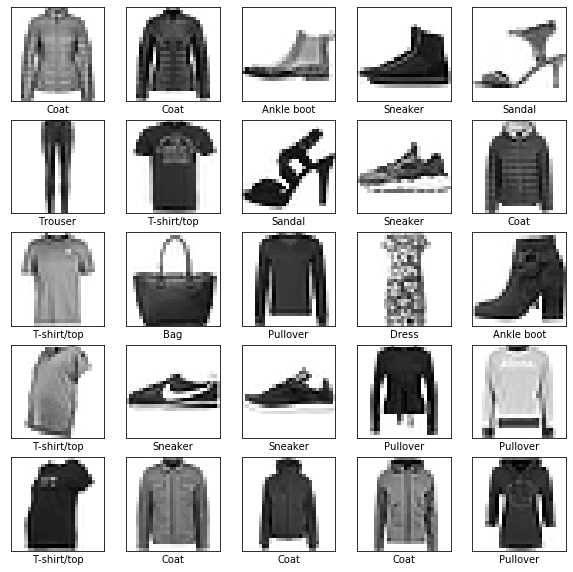

In [11]:
plt.figure(figsize=(10,10))
i=0
for(image, label) in test_dataset.take(25):
  image = image.numpy().reshape((28,28))
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image, cmap=plt.cm.binary)
  plt.xlabel(class_names[label])
  i += 1
plt.show()

# Build the model
Building the neural network requires configuring the layers of the model, then compiling the model.


# Setup the layers
The basic building block of a neural network is the layer. A layer extracts a representation from the data fed into it. Hopefully, a series of connected layers results in a representation that is meaningful for the problem at hand.

Much of deep learning consists of chaining together simple layers. Most layers, like `tf.keras.layers.Dense`, have internal parameters which are adjusted ("learned") during training.


In [0]:
model = tf.keras.Sequential([
       tf.keras.layers.Flatten(input_shape=(28,28,1)),
       tf.keras.layers.Dense(128,activation=tf.nn.relu),
       tf.keras.layers.Dense(10)                      
])

This network has three layers:

input tf.keras.layers.Flatten — This layer transforms the images from a 2d-array of 28  ×  28 pixels, to a 1d-array of 784 pixels (28*28). Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn, as it only reformats the data.

"hidden" tf.keras.layers.Dense— A densely connected layer of 128 neurons. Each neuron (or node) takes input from all 784 nodes in the previous layer, weighting that input according to hidden parameters which will be learned during training, and outputs a single value to the next layer.

output tf.keras.layers.Dense — A 10-node softmax layer, with each node representing a class of clothing. As in the previous layer, each node takes input from the 128 nodes in the layer before it. Each node weights the input according to learned parameters, and then outputs a value in the range [0, 1], representing the probability that the image belongs to that class. The sum of all 10 node values is 1.

#Compile the model
Loss function — An algorithm for measuring how far the model's outputs are from the desired output. The goal of training is this measures loss.

Optimizer —An algorithm for adjusting the inner parameters of the model in order to minimize loss.

Metrics —Used to monitor the training and testing steps. The following example uses accuracy, the fraction of the images that are correctly classified.

In [0]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
First, we define the iteration behavior for the train dataset:




> Repeat forever by specifying 

> dataset.repeat() (the epochs parameter described below limits how long we perform training).

>The dataset.shuffle(60000) randomizes the order so our model cannot learn anything from the order of the examples.

>And dataset.batch(32) tells model.fit to use batches of 32 images and labels when updating the model variables.


Training is performed by calling the model.fit method:

>Feed the training data to the model using train_dataset.

>The model learns to associate images and labels.

> The epochs=5 parameter limits training to 5 full iterations of the training dataset, so a total of 5 * 60000 = 300000 examples.

In [0]:
BATCH_SIZE = 32
train_dataset = train_dataset.repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [15]:
model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_test_examples/BATCH_SIZE))

Train for 313 steps
Epoch 1/5
313/313 [==============================] - 3s 11ms/step - loss: 0.7254 - accuracy: 0.7443
Epoch 2/5
313/313 [==============================] - 1s 3ms/step - loss: 0.4962 - accuracy: 0.8241
Epoch 3/5
313/313 [==============================] - 1s 3ms/step - loss: 0.4534 - accuracy: 0.8412
Epoch 4/5
313/313 [==============================] - 1s 3ms/step - loss: 0.4137 - accuracy: 0.8560
Epoch 5/5
313/313 [==============================] - 1s 3ms/step - loss: 0.3990 - accuracy: 0.8542


# Evaluate accuracy
Next, compare how the model performs on the test dataset. Use all examples we have in the test dataset to assess accuracy.

In [16]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - 3s 8ms/step - loss: 55.9476 - accuracy: 0.8384
Accuracy on test dataset: 0.8384


# Make predictions and explore
With the model trained, we can use it to make predictions about some images.

In [0]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

In [21]:
predictions.shape

(32, 10)

Here, the model has predicted the label for each image in the testing set. Let's take a look at the first prediction:

In [22]:
predictions[0]

array([ -354.27713,  -483.7603 ,   840.542  ,  -934.961  ,  1693.9641 ,
       -1874.6105 ,   849.71356, -2684.5583 ,  -348.89594, -1969.3883 ],
      dtype=float32)

A prediction is an array of 10 numbers. These describe the "confidence" of the model that the image corresponds to each of the 10 different articles of clothing. We can see which label has the highest confidence value:

In [23]:
np.argmax(predictions[0])

4

So the model is most confident that this image is a coat, or class_names[4]. And we can check the test label to see this is correct:

In [26]:
test_labels[0]

4

We can graph this to look at the full set of 10 class predictions

In [0]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)
def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Let's look at the 0th image, predictions, and prediction array.

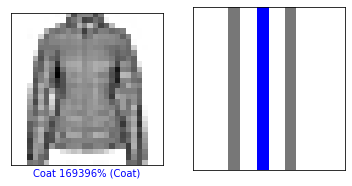

In [31]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

Let's plot several images with their predictions. Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percent (out of 100) for the predicted label. Note that it can be wrong even when very confident.

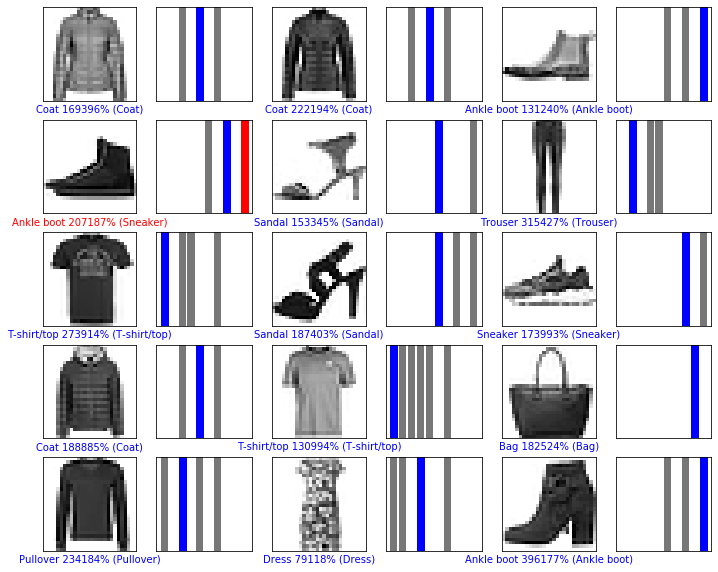

In [32]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)


Finally, use the trained model to make a prediction about a single image.

In [33]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

(28, 28, 1)


tf.keras models are optimized to make predictions on a batch, or collection, of examples at once. So even though we're using a single image, we need to add it to a list:

In [34]:
# Add the image to a batch where it's the only member.
img = np.array([img])

print(img.shape)

(1, 28, 28, 1)


Now predict the image:

In [35]:
predictions_single = model.predict(img)

print(predictions_single)

[[ -354.27707  -483.76047   840.542    -934.9611   1693.9639  -1874.6108
    849.7134  -2684.5583   -348.8959  -1969.3883 ]]


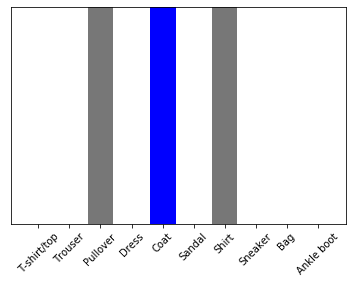

In [39]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)